In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive

/content/drive


In [0]:
cd "My Drive/image_segmentation"

/content/drive/My Drive/image_segmentation


In [0]:
!pwd

/content/drive/My Drive/image_segmentation


In [0]:
import os
import datetime
import glob
import random
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.io import imread,imshow                               
from skimage.transform import resize
from skimage.color import rgb2gray                     
from skimage.morphology import label                  

import numpy as np
import pandas as pd

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import multi_gpu_model, plot_model
from keras import backend as K
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)

img_height,img_width = (256,256)
img_channels = 3

Using TensorFlow backend.


Python       : 3.6.9 (default, Nov  7 2019, 10:44:02) 
Numpy        : 1.17.5
Scikit-learn : 0.22.1
Keras        : 2.2.5
Tensorflow   : 1.15.0


In [0]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

In [0]:
train_path = 'train_img'
test_path = 'test_img'

In [0]:
'''try:
    train_ids = sorted(next(os.walk(train_path))[1])
except StopIteration:
    pass # Some error handling here
try:
    test_ids = sorted(next(os.walk(test_path))[1])
except StopIteration:
    pass # Some error handling here'''

'try:\n    train_ids = sorted(next(os.walk(train_path))[1])\nexcept StopIteration:\n    pass # Some error handling here\ntry:\n    test_ids = sorted(next(os.walk(test_path))[1])\nexcept StopIteration:\n    pass # Some error handling here'

In [0]:
'''X_train = np.zeros((len(train_ids),img_height,img_width,img_channels),dtype=np.uint8)
Y_train = np.zeros((len(train_ids),img_height,img_width,1),dtype=np.uint8)

print('Getting and resizing train images and masks')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path +'/'+ id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]
    img = resize(img, (img_height, img_width),mode='constant',preserve_range=True)
    X_train[n] = img
    mask_ = imread(path + '/images/' + 'mask.png')
    mask_ = rgb2gray(mask_)
    mask_ = np.expand_dims(mask_, axis=-1)
    Y_train[n] = mask_

np.save('X_train1',X_train)
np.save('Y_train1',Y_train)
X_test = np.zeros((len(test_ids),img_height,img_width,img_channels),dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images')
sys.stdout.flush()

for n,id_ in tqdm(enumerate(test_ids),total = len(test_ids)):
  path = test_path + '/' + id_
  
  img = imread(path+'/images/'+id_+'.png')[:,:,:img_channels]
  sizes_test.append([img.shape[0],img.shape[1]])
  img = resize(img,(img_height,img_width),mode='constant',preserve_range=True)
  X_test[n] = img
np.save('X_test1',X_test)
print('Done!')'''

"X_train = np.zeros((len(train_ids),img_height,img_width,img_channels),dtype=np.uint8)\nY_train = np.zeros((len(train_ids),img_height,img_width,1),dtype=np.uint8)\n\nprint('Getting and resizing train images and masks')\nsys.stdout.flush()\nfor n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):\n    path = train_path +'/'+ id_\n    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]\n    img = resize(img, (img_height, img_width),mode='constant',preserve_range=True)\n    X_train[n] = img\n    mask_ = imread(path + '/images/' + 'mask.png')\n    mask_ = rgb2gray(mask_)\n    mask_ = np.expand_dims(mask_, axis=-1)\n    Y_train[n] = mask_\n\nnp.save('X_train1',X_train)\nnp.save('Y_train1',Y_train)\nX_test = np.zeros((len(test_ids),img_height,img_width,img_channels),dtype=np.uint8)\nsizes_test = []\nprint('Getting and resizing test images')\nsys.stdout.flush()\n\nfor n,id_ in tqdm(enumerate(test_ids),total = len(test_ids)):\n  path = test_path + '/' + id_\n  \n  img = im

In [0]:
X_train = np.load('X_train1.npy')
X_test = np.load('X_test1.npy')
Y_train = np.load('Y_train1.npy')
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(670, 256, 256, 3)
(670, 256, 256, 1)
(65, 256, 256, 3)


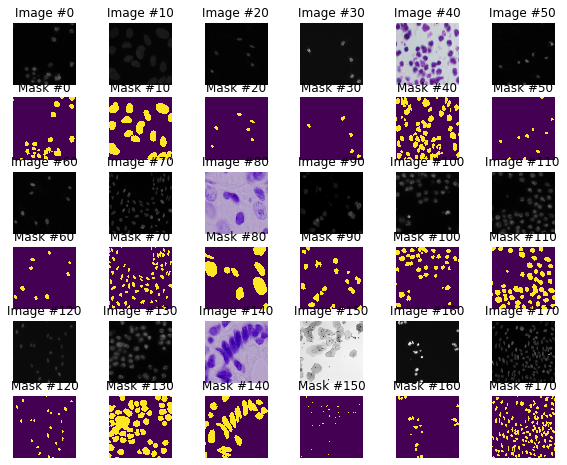

In [0]:
plt.figure(figsize=(10,8))
x,y = 6,3

for i in range(y):
  for j in range(x):
    plt.subplot(y*2,x,i*2*x+j+1)
    pos = i*60 + j*10
    plt.imshow(X_train[pos])
    plt.title('Image #{}'.format(pos))
    plt.axis('off')
    plt.subplot(y*2,x,(i*2+1)*x+j+1)
    pos = i*60 +j*10
    plt.imshow(np.squeeze(Y_train[pos]))
    plt.title('Mask #{}'.format(pos))
    plt.axis('off')
plt.show()

In [0]:
def keras_model(img_width=256,img_height=256):

  n_ch_exps = [4,5,6,7,8,9]
  k_size = (3,3)
  k_init = 'he_normal'

  if K.image_data_format() == 'channels_first':
    ch_axis = 1
    input_shape = (3,img_width,img_height)
  else:
    ch_axis = 3
    input_shape = (img_width,img_height,3)
  
  inp = Input(shape = input_shape)
  encodes = []

  enc = inp
  print(n_ch_exps)
  for l_idx,n_ch in enumerate(n_ch_exps):

    enc = Conv2D(filters = 2**n_ch,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(enc)
    enc = Dropout(0.2)(enc)
    enc = Conv2D(filters = 2**n_ch,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(enc)
    encodes.append(enc)

    if n_ch < n_ch_exps[-1]:
      enc = MaxPooling2D(pool_size=(2,2))(enc)

  dec = enc
  print(n_ch_exps[::-1][1:])
  decoder_n_chs = n_ch_exps[::-1][1:]

  for l_idx,n_ch in enumerate(decoder_n_chs):
    l_idx_rev = len(n_ch_exps) - l_idx -2
    dec = Conv2DTranspose(filters=2**n_ch,kernel_size=k_size,strides=(2,2),activation='relu',padding='same',kernel_initializer=k_init)(dec)
    dec = concatenate([dec,encodes[l_idx_rev]],axis=ch_axis)
    dec = Conv2D(filters=2**n_ch,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(dec)
    dec = Dropout(0.2)(dec)
    dec = Conv2D(filters=2**n_ch,kernel_size=k_size,activation='relu',padding='same',kernel_initializer=k_init)(dec)
  
  outp = Conv2DTranspose(filters=1,kernel_size=k_size,activation='sigmoid',padding='same',kernel_initializer='glorot_normal')(dec)
  model = Model(inputs=[inp],outputs=[outp])

  return model  

In [0]:
def mean_iou(y_true,y_pred):
  prec = []
  for t in np.arange(0.5,1.0,0.05):

    y_pred_ = tf.to_int32(y_pred>t)
    score,up_opt = tf.metrics.mean_iou(y_true,y_pred_,2)
    
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
      score = tf.identity(score)
    prec.append(score)
  return K.mean(K.stack(prec),axis=0)

def dice_coeff(y_true,y_pred):
  smooth = 1
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f*y_pred_f)
  return (2.0 * intersection + smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)

def bce_dice_loss(y_true,y_pred):
  return 0.5*keras.losses.binary_crossentropy(y_true,y_pred) - dice_coeff(y_true,y_pred)

In [0]:
optimizer = 'adam'
loss = bce_dice_loss
metrics = [mean_iou]

model = keras_model(img_width=img_width,img_height=img_height)
model.summary()

model.compile(optimizer=optimizer,loss=loss,metrics=metrics)



[4, 5, 6, 7, 8, 9]


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

[8, 7, 6, 5, 4]
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (Non

In [0]:
def get_train_test_augmented(X_data=X_train,Y_data=Y_train,validation_split=0.1,batch_size=32,seed=seed):

  X_train,X_test,Y_train,Y_test = train_test_split(X_data,Y_data,train_size=1-validation_split,
                                                   test_size=validation_split,random_state=seed)

  data_gen_args = dict(rotation_range=45,
                       width_shift_range=0.1,
                       height_shift_range=0.1,
                       shear_range=0.2,
                       zoom_range=0.2,
                       horizontal_flip=True,
                       vertical_flip=True,
                       fill_mode='reflect')
  
  X_datagen = ImageDataGenerator(**data_gen_args)
  Y_datagen = ImageDataGenerator(**data_gen_args)

  X_datagen.fit(X_train,augment=True,seed=seed)
  Y_datagen.fit(Y_train,augment=True,seed=seed)

  X_train_augmented = X_datagen.flow(X_train,batch_size=batch_size,shuffle=True,seed=seed)
  Y_train_augmented = Y_datagen.flow(Y_train,batch_size=batch_size,shuffle=True,seed=seed)

  X_datagen_val = ImageDataGenerator()
  Y_datagen_val = ImageDataGenerator()

  X_datagen_val.fit(X_test,augment=True,seed=seed)
  Y_datagen_val.fit(Y_test,augment=True,seed=seed)

  X_test_augmented = X_datagen_val.flow(X_test,batch_size=batch_size,shuffle=True,seed=seed)
  Y_test_augmented = Y_datagen_val.flow(Y_test,batch_size=batch_size,shuffle=True,seed=seed)

  train_generator = zip(X_train_augmented,Y_train_augmented)
  test_generator = zip(X_test_augmented,Y_test_augmented)

  return train_generator,test_generator,X_train,X_test,Y_train,Y_test

In [0]:
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from IPython.display import clear_output
#from matplotlib.ticker import FormatStrFormatter

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Log-loss (cost function)"}
    if x in translations:
        return translations[x]
    else:
        return x

class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(1, len(self.base_metrics), metric_id + 1)
            
            plt.plot(range(1, len(self.logs) + 1),
                     [log[metric] for log in self.logs],
                     label="training")
            if self.params['do_validation']:
                plt.plot(range(1, len(self.logs) + 1),
                         [log['val_' + metric] for log in self.logs],
                         label="validation")
            plt.title(translate_metric(metric))
            plt.xlabel('epoch')
            plt.legend(loc='center left')
        
        plt.tight_layout()
        plt.show();
plot_losses = PlotLosses(figsize=(16, 4))

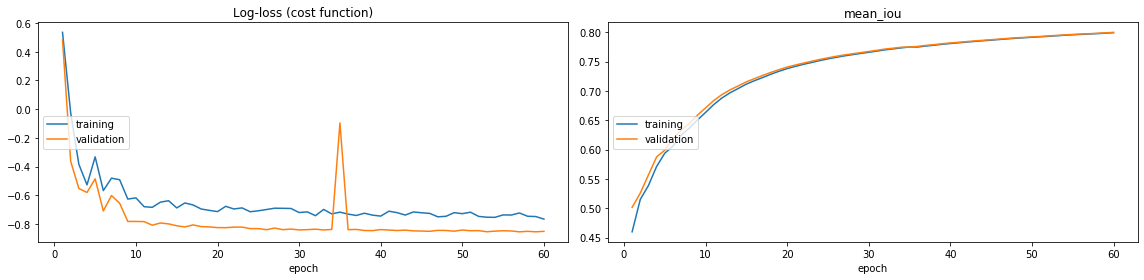

In [0]:
batch_size=16
train_generator,test_generator,X_train,X_test,Y_train,Y_test = get_train_test_augmented(X_data=X_train,
                                                                                        Y_data=Y_train,
                                                                                        validation_split=0.1,
                                                                                        batch_size=batch_size)
checkpoint = ModelCheckpoint('unet.h5',save_best_only=True,verbose=1)
model.fit_generator(train_generator,validation_data=test_generator,validation_steps=batch_size/2,
                    steps_per_epoch = len(X_train)//batch_size,epochs=60,verbose=1,callbacks=[checkpoint,plot_losses])


In [0]:
model.save_weights('unet-weights.hdf5')

In [0]:
model_loaded = keras_model(img_width=img_width,img_height=img_height)
model_loaded.load_weights('unet-weights.hdf5')

[4, 5, 6, 7, 8, 9]
[8, 7, 6, 5, 4]


In [0]:
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,train_size=0.9,
                                                   test_size=0.1,random_state=seed)


In [0]:
preds_val = model.predict(X_val,verbose=1)
preds_val_t = preds_val>0.5

55/55 [==============================] - 4s 72ms/step


In [0]:
def cal_iou(A,B):
  inter = np.logical_and(A,B);
  union = np.logical_or(A,B);
  iou = np.sum(inter>0)/np.sum(union>0)
  return iou

In [0]:
iou = []
for i in range(len(Y_val)):
  iou.append(cal_iou(np.squeeze(Y_val[i]),np.squeeze(preds_val_t[i])))

print('Average Validate IOU {}'.format(round(np.mean(iou),2)))

Average Validate IOU 0.82


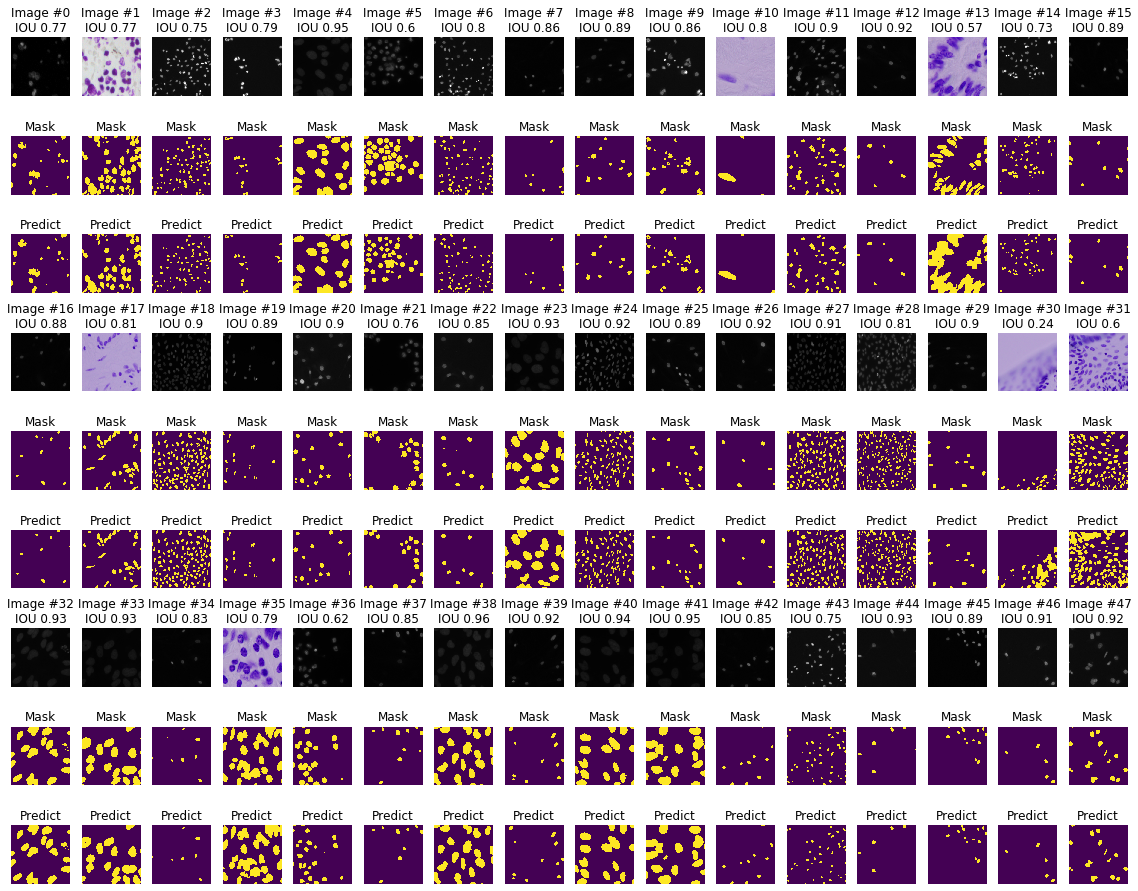

In [0]:
#plt.figure(figsize=(20,10.5))
plt.figure(figsize=(20,16))
x, y = 16,3
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*3, x, i*3*x+j+1)
        pos = i*x+j
        plt.imshow(X_val[pos])
        plt.title('Image #{}\nIOU {}'.format(pos,round(cal_iou(np.squeeze(Y_val[pos]), np.squeeze(preds_val_t[pos])),2)))
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+1)*x+j+1)
        plt.imshow(np.squeeze(Y_val[pos]))
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+2)*x+j+1)
        plt.imshow(np.squeeze(preds_val_t[pos]))
        plt.title('Predict')
        plt.axis('off')
plt.show()

In [0]:
X_test = np.load('X_test1.npy')
Y_hat = model_loaded.predict(X_test,verbose=1)
print(Y_hat.shape)

65/65 [==============================] - 1s 19ms/step
(65, 256, 256, 1)


(256, 256, 3)


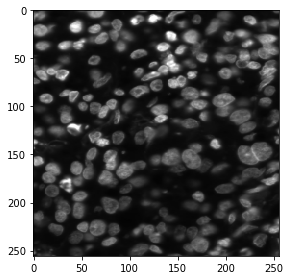

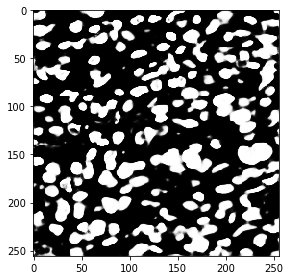

In [0]:
id = 32
print(X_test[id].shape)
imshow(X_test[id])
plt.show()
imshow(Y_hat[id][:,:,0])
plt.show()